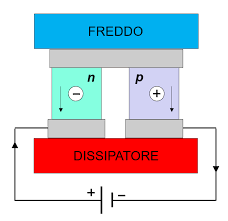

In [6]:
from IPython.display import Image, display

images = [
    Image("Media/Cella di Pelteir.png")
]
display(*images)

## Celle di Peltier

### Configurazione della lettura seriale PR59
- Abbiamo usato la libreria "pyserial" con modulo "Serial"

- Abbiamo overclocckato la priorità usando il modulo "psutil.Process" perchè ci siamo accorti che abbassando la finestra dell'output di python cambiasse la priorità che il sistema dedicasse al programma, con conseguenza che aumentasse la frequenza di correzione della temperatura del PID e questo non lo volevamo

- Abbiamo modificato il programma per renderlo disponibile ad accettare comandi durante l'esecuzione del programma

----
### Strumenti e ciclo di misura

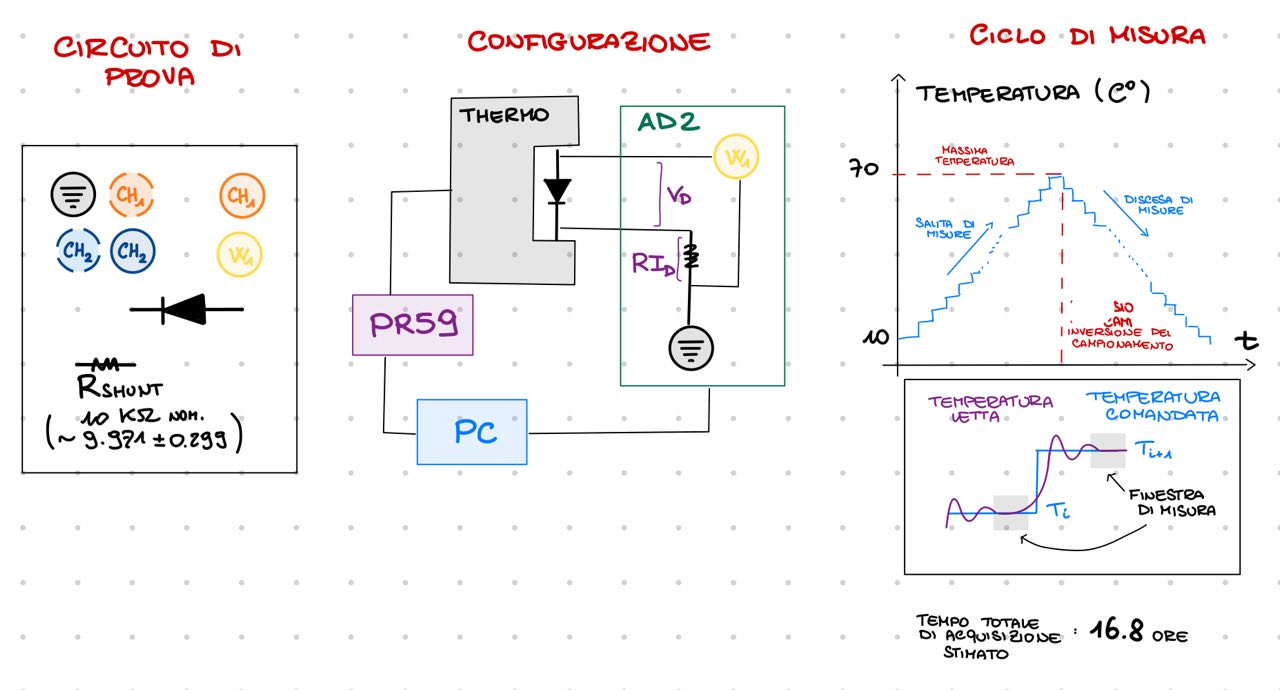

In [9]:
images = [
    Image("Media/Framework.jpg",width=900)
]
display(*images)

$R_{shunt}=9.971 \pm 0.299 k\Omega$

Descrizione del ciclo di misura
- Per ogni temperatura vengono effettuati due sweep in tensione $V_{go}$ e $V_{return}$
- Vengono effettuati un ciclo di temperatura di salita e di discesa

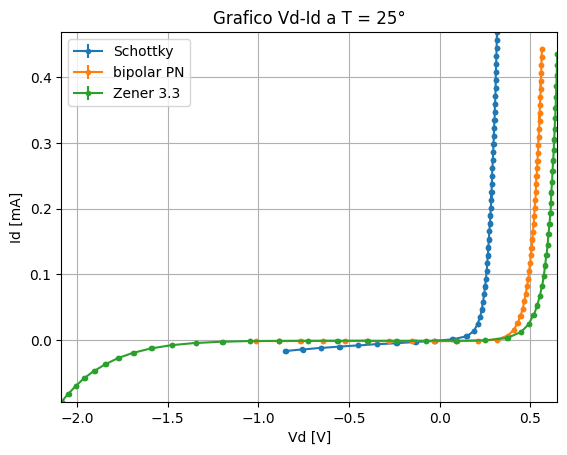

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#%matplotlib widget

# Funzione per caricare e ordinare i dati
def load_and_sort_data(data):
    Td_go, Td_return, Vc, Vd_go, Vd_return, ErrVd_go, ErrVd_return, Vr_go, Vr_return, ErrVr_go, ErrVr_return, Id_go, Id_return, ErrId_go, ErrId_return = data
    V = np.concatenate((Vd_go, Vd_return))
    I = np.concatenate((Id_go, Id_return)) * 1e3  # Conversione a mA
    err_V = np.concatenate((ErrVd_go, ErrVd_return))
    err_I = np.concatenate((ErrId_go, ErrId_return))
    idx = np.argsort(V)
    V = V[idx]
    I = I[idx]
    return V, I, err_V, err_I

# Caricamento dei dati
data_bipolar = np.loadtxt("Data/IV-T_dependence_20250404_100546/IV_T25.00_V-1.00_5.00_0Pull_TGo.txt", unpack=True)
V_bipolar, I_bipolar, dV_bipolar, dI_bipolar = load_and_sort_data(data_bipolar)

data_schottky = np.loadtxt("Data/IV-T_dependence_20250408_110423/IV_T25.00_V-1.00_5.00_0Pull_TGo.txt", unpack=True)
V_schottky, I_schottky, dV_schottky, dI_schottky = load_and_sort_data(data_schottky)

data_zener33 = np.loadtxt("Data/IV-T_dependence_20250408_124236/IV_T25.00_V-3.00_5.00_0Pull_TGo.txt", unpack=True)
V_zener33, I_zener33, dV_zener33, dI_zener33 = load_and_sort_data(data_zener33)

# Grafico
plt.errorbar(V_schottky, I_schottky,xerr=dV_schottky, yerr=dI_schottky, label="Schottky", marker=".")
plt.errorbar(V_bipolar, I_bipolar,xerr=dV_bipolar, yerr=dI_bipolar, label="bipolar PN", marker=".")
plt.errorbar(V_zener33, I_zener33,xerr=dV_zener33, yerr=dI_zener33, label="Zener 3.3", marker=".")

plt.title("Grafico Vd-Id a T = 25°")
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel("Vd [V]")
plt.ylabel("Id [mA]")
plt.legend()
plt.grid()
plt.show()

-----
### Risposta del diodo al variare della temperatura
Vorremmo fittare la seguente funzione:

$\boxed{I_d = I_s\left[ e^{\frac{eV}{\eta k_B T}}-1\right]}$ con in generale una corrente di saturazione $\boxed{I_s = I_0 T^\gamma e^{\frac{E_0}{\eta k_B T}}}$:

- $\text{\textbf{Modello di Shockley}}$: per un diodo bipolare consideriamo:
    - Esponente: $\gamma = \frac{3}{2}$, 
    - Energia di ground state: $E_0 \approx 1.1 eV$, 
    - Fattore di idealità: $\eta \in [1,2]$

- $\text{\textbf{Modello di Richardson}}$: per un diodo unipolare consideriamo:
    - Esponente: $\gamma = 2$, 
    - Altezza della barriera Schottky: $E_0$, 
    - Fattore di idealità: $\eta =1$

$\text{\textbf{Modello Zener}}$: per un diodo zener consideriamo:

$\boxed{I(V, T) \approx
\begin{cases}
I_s(T) \left( e^{\frac{qV}{n k T}} - 1 \right) & \text{se}\quad V > 0 \\
-I_s(T) \left( e^{\frac{-q(V + V_Z(T))}{n k T}} - 1 \right) & \text{se}\quad  V < -V_Z(T) \\
I_\text{leak}(T) & \text{se}\quad  -V_Z(T) < V < 0
\end{cases}}$

con:
- $\boxed{I_s(T) = I_0 T^2 e^{\frac{-E_g}{k_B T}} }$ (comportamento Schottky)

- $\boxed{V_Z(T) = V_Z(T_0) + \Delta V_Z(T-T_0) }$ (voltaggio di soglia comportamento Zener)

- $\boxed{I_{leak}(T) = I_{leak}(T_0) T^2 e^{\frac{-E_g}{k_B T}} }$ con $I_{leak}(T_0)\ll I_0\quad$ (corrente di fuga inversa)

Effettueremo le seguenti scelte:
- Spezziamo i dati dello Zenner nelle tre aree e le fitteremo separatamente
- Fissiamo un valore $T_0\approx 35°$ circa in mezzo all'intervallo di temperatura e trascuriamo $\Delta V_Z(T-T_0)$
- Consideriamo $I_{leak}(T)\approx I_{leak}(T_0)$ data la slope molto bassa

----
### Test del funzionamento del diodo a temperatura fissata
Osserviamo la temperatura $T=25°$ dal controller della temperatura seriale contemporaneamente corrente $I_d$ e tensione $V$ tramite AD2.

- "IV-T_dependence_20250404_100546" è la cartella con presa dati completa del diodo PN
- "IV-T_dependence_20250408_110423" è la cartella con presa dati completa del diodo Shottky
- "IV-T_dependence_20250408_124236" è la cartella con presa dati completa del diodo Zener 3.3

/var/folders/q8/5bxz228s2vv15c436kznwm3r0000gn/T/ipykernel_29919/3105853936.py:11: RuntimeWarning: overflow encountered in power
  Is = I0 * T**gam * np.exp(-Eg / (n * k * T))


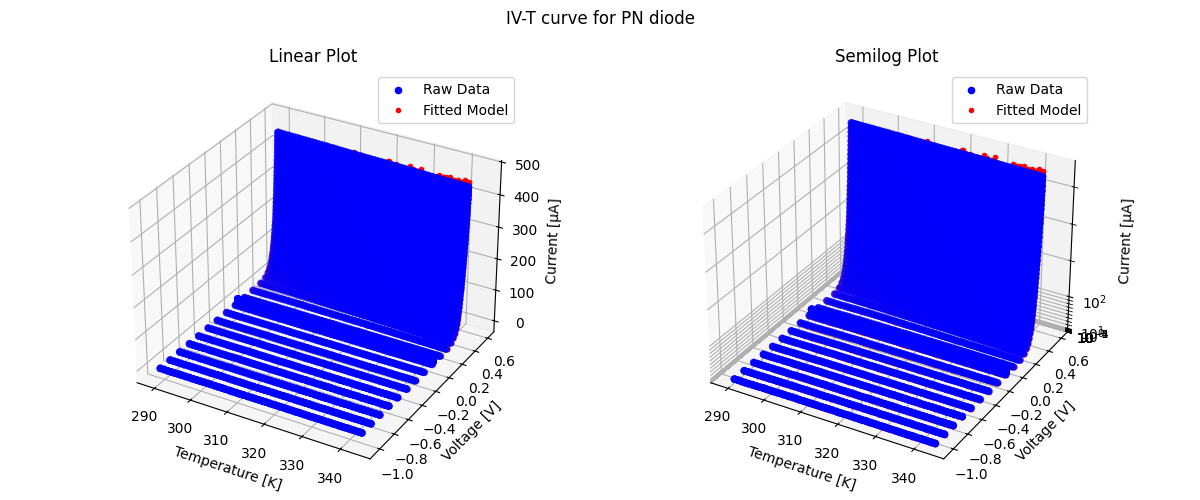

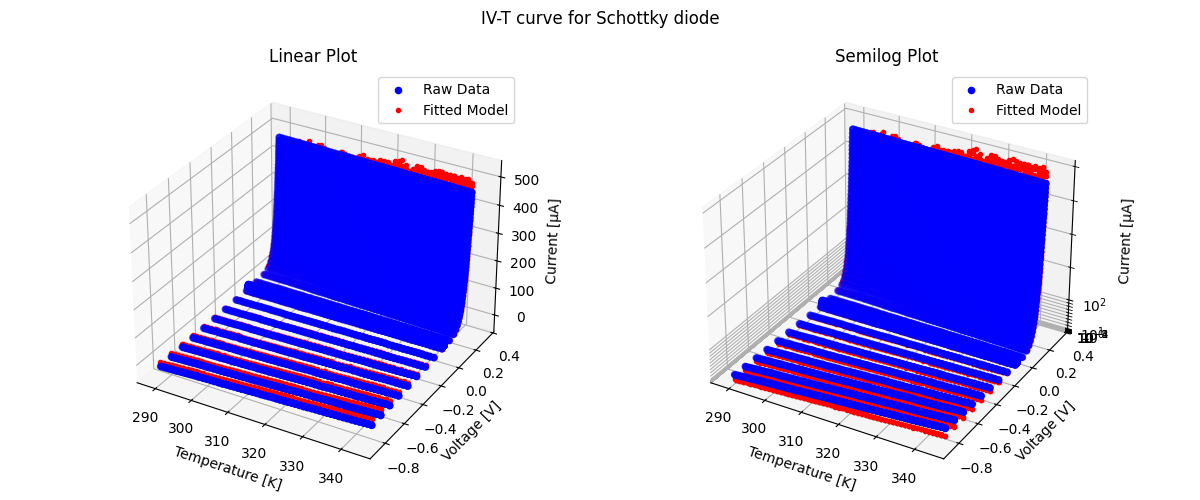

/var/folders/q8/5bxz228s2vv15c436kznwm3r0000gn/T/ipykernel_29919/3105853936.py:11: RuntimeWarning: invalid value encountered in multiply
  Is = I0 * T**gam * np.exp(-Eg / (n * k * T))


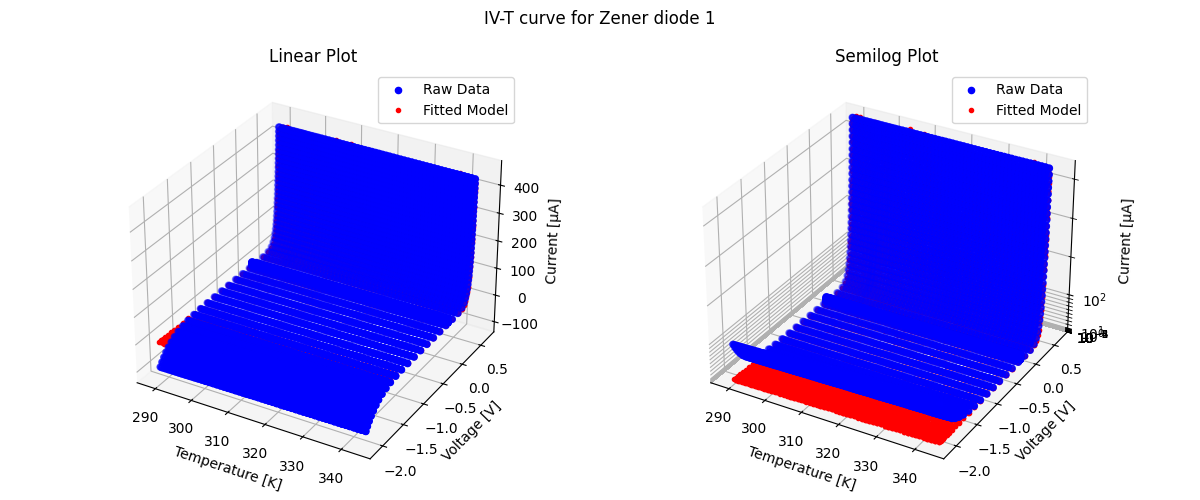

In [8]:
import numpy as np
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib widget

# Modelli
def PN_model(X, I0, gam, Eg, n):
    V, T = X
    k, Vt = 8.617333e-5, 13e-3
    Is = I0 * T**gam * np.exp(-Eg / (n * k * T))
    return Is * (np.exp(V / (n * Vt)) - 1) * 1e6

def Schottky_model(X, I0, gam, Esh, n):
    V, T = X
    k, Vt = 8.617333e-5, 13e-3
    Is = I0 * T**gam * np.exp(-Esh / (k * T))
    return Is * (np.exp(V / (n * Vt)) - 1) * 1e6

def Zener_model(X, I0, gam, Eg, n):
    return PN_model(X, I0, gam, Eg, n)

# Parametri

names = ['PN diode', 'Schottky diode', 'Zener diode 1', 'Zener diode 2']
filenames = [
    'IV-T_dependence_20250404_100546/',
    'IV-T_dependence_20250408_110423/',
    'IV-T_dependence_20250408_124236/',
    'IV-T_dependence_20250408_/'
]
for choose_diode in range(1,4):
    base_path = os.path.join('Data', filenames[choose_diode - 1])
    temps = np.arange(16, 71)

    if choose_diode in (1,2):
        offsets = [-1, 5]
    else: offsets = [-3, 5]

    pulls = range(3)
    flag_return_T = flag_return_V = True

    # Lettura dati
    V_all, T_all, I_all = [], [], []

    def filename(T, offsets, pull, direction):
        dir_str = 'Go' if direction == 1 else 'Return'
        return f'IV_T{T:.2f}_V{offsets[0]:.2f}_{offsets[1]:.2f}_{pull}Pull_T{dir_str}.txt'

    for direction in [1, 2] if flag_return_T else [1]:
        for T in reversed(temps) if direction == 2 else temps:
            for pull in pulls:
                path = os.path.join(base_path, filename(T, offsets, pull, direction))
                try:
                    data = np.loadtxt(path)
                    V_all.extend(data[:, 4 if direction == 1 else 5])
                    T_all.extend(data[:, 0 if direction == 1 else 1])
                    I_all.extend(data[:, 12 if direction == 1 else 13])
                except Exception:
                    continue

    T_all = np.array(T_all) + 273.15
    V_all = np.array(V_all)
    I_all = np.array(I_all) * 1e6
    X = np.vstack((V_all, T_all))

    # Fit
    p0_dict = {
        1: [2e-8, 1.5, 1.8, 2],
        2: [2e-8, 2, 0.3, 2],
        3: [2e-8, 1.8, 1.8, 4],
        4: [2e-8, 1.8, 1.8, 4]
    }
    models = {1: PN_model, 2: Schottky_model, 3: Zener_model, 4: Zener_model}
    p0 = p0_dict[choose_diode]
    model = models[choose_diode]
    beta, _ = curve_fit(model, X, I_all, p0, maxfev=100000)

    # Plot
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    I_fit = model(X, *beta)
    for ax, scale, title in zip([ax1, ax2], ['linear', 'log'], ['Linear Plot', 'Semilog Plot']):
        Z = np.abs(I_all) if scale == 'log' else I_all
        Z_fit = np.abs(I_fit) if scale == 'log' else I_fit

        if scale == 'log':
            valid_Z = Z[Z > 0]
            valid_Z_fit = Z_fit[Z_fit > 0]
            if len(valid_Z) > 0 and len(valid_Z_fit) > 0:
                z_min = 0.1 * min(np.min(valid_Z), np.min(valid_Z_fit))
                z_max = max(np.max(valid_Z), np.max(valid_Z_fit))
                ax.set_zlim(z_min, z_max)

        ax.scatter(T_all, V_all, Z, label='Raw Data', color='blue')
        ax.plot(T_all, V_all, Z_fit, 'r.', label='Fitted Model')
        ax.set_xlabel('Temperature [K]')
        ax.set_ylabel('Voltage [V]')
        ax.set_zlabel('Current [μA]')
        ax.set_title(title)
        if scale == 'log': ax.set_zscale('log')
        ax.legend()

    fig.suptitle(f'IV-T curve for {names[choose_diode - 1]}')
    plt.tight_layout()
    plt.show()
